# Permutation Tests

This notebook will introduce permutation methods for comparison two groups.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

## Permutation method for two independent samples

Let's use a permutation test to determine whether the two means (classC and classD) are diferent from each other.

The method is very similar to the bootstrap, but a fundamental difference between them is that the bootstrap resamples with replacement and the permutation test does not. Then, we will use `np.random.choice()` with `replace=False` 

Hypothesis

- `Ho: mean_C  = mean_D     or     mean_C - mean_D  = 0`
- `Ha: mean_C != mean_D     or     mean_C - mean_D != 0`

Let's generate values for classes C and D:

In [2]:
np.random.seed(123)
classC = np.random.normal(85, 3, 100)
classD = np.random.normal(90, 3, 95)

 The means of `classC` and `classD` are different.

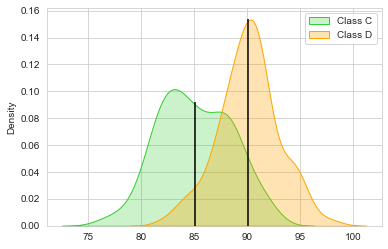

In [3]:
ax=sns.kdeplot(x=classC, color='limegreen', shade=True, label='Class C')
ax.vlines(x=np.mean(classC), ymin=0, ymax=0.092, color='black')
ax=sns.kdeplot(x=classD, color='orange', shade=True, alpha=0.3, label='Class D')
ax.vlines(x=np.mean(classD), ymin=0, ymax=0.154, color='black')
plt.legend();

In [4]:
print('Mean of class C = %.2f' % np.mean(classC))
print('Mean of class D = %.2f' % np.mean(classD))

Mean of class C = 85.08
Mean of class D = 90.07


The number of students in each class is also different.

In [5]:
print('Lenght of class C =', len(classC))
print('Lenght of class D =', len(classD))

Lenght of class C = 100
Lenght of class D = 95


Let's pool all the data together and randomly split the data into two groups: classC and classD.

We will repeat the process many times (about 10**4)

**Main idea**: If there is truly no difference between the averages grades of classC and classD, there will be no differences between the average grades of the generated groups.

`generateSamplesPerm` is the function for generating samples WITHOUT replacement

In [6]:
def generateSamplesPerm_2i(sample1, sample2, num_samples=10000):
    '''
    It concatenates both samples, shuffle it, and creates two new samples with 
    the same length of the originals. 
    It returns two DataFrames, where each column is a sample without replacement.
    '''
    pool = np.concatenate([sample1, sample2])
    col = ['S'+str(k) for k in range(num_samples)]
    df1 = pd.DataFrame(sample1[0], index=range(len(sample1)), columns=col)
    df2 = pd.DataFrame(sample2[0], index=range(len(sample2)), columns=col)
    for c in col:
        pool = np.random.choice(pool, replace=False, size=len(pool))
        df1[c] = pool[:len(sample1)]
        df2[c] = pool[len(sample1):]   
    return(df1, df2)

In [7]:
# generating samples for classC and classD
dfC, dfD = generateSamplesPerm_2i(classC, classD)

In [8]:
print(dfC.shape)
dfC.head()

(100, 10000)


,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S9990,S9991,S9992,S9993,S9994,S9995,S9996,S9997,S9998,S9999
0,90.922153,83.696946,82.399779,87.065827,84.066336,88.716961,88.119181,82.361391,88.308228,88.797809,...,89.910096,89.189303,81.117744,76.604233,87.777559,87.721316,79.685401,86.158559,82.583900,85.887155
1,92.113422,90.531577,81.742293,82.192498,89.621647,82.933393,85.764333,83.083294,95.417910,83.086745,...,88.207948,83.924863,94.826073,89.251897,84.233142,88.343676,90.390645,82.328836,87.304731,88.923192
2,87.529706,88.935527,81.746296,83.713262,87.065827,82.399779,88.533586,84.369394,83.083294,80.713958,...,89.621647,89.002574,80.481116,80.481116,91.661568,88.308228,91.174753,90.970407,86.853025,80.713958
3,93.801896,88.765712,92.136794,89.472196,84.964509,88.407976,82.414735,90.922153,81.743108,81.117744,...,94.131772,86.015767,90.598746,83.083294,83.264199,90.761449,83.713262,82.900368,90.362242,87.782387
4,92.244647,91.560358,85.543105,90.231137,87.529706,82.328836,90.836223,94.378768,80.481116,90.402080,...,91.503747,90.264659,87.721316,82.487450,88.308228,86.015767,90.598746,86.405317,88.825141,93.728609


In [9]:
print(dfD.shape)
dfD.head()

(95, 10000)


,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,S9990,S9991,S9992,S9993,S9994,S9995,S9996,S9997,S9998,S9999
0,85.136470,84.479093,81.743108,81.405097,88.353135,88.354074,89.418108,92.244647,88.527487,84.066336,...,81.708391,88.935527,82.900368,82.361391,91.617790,86.941035,87.782387,84.715873,84.715873,85.942816
1,81.117744,85.942816,86.015767,95.417910,91.714430,76.604233,85.887155,85.493324,85.136470,83.713262,...,87.782387,83.083294,90.280382,91.996960,87.421925,88.450617,88.093343,94.186059,80.713958,79.816992
2,86.941035,83.083294,77.719962,85.887155,89.926122,89.280994,87.421710,88.308228,90.591057,90.390645,...,87.529706,88.938000,86.941035,88.119181,89.176810,89.926122,86.405317,85.543105,87.730688,84.233142
3,81.021204,83.086745,90.922153,94.570991,88.450617,88.353239,84.300724,81.746296,81.238358,90.531577,...,80.481116,88.119181,76.604233,77.719962,86.138202,83.086745,93.728609,82.487450,82.328836,92.282848
4,84.066336,87.008036,89.474169,91.368813,81.743108,83.924863,86.158559,88.938000,94.378768,87.730688,...,86.941035,90.419934,89.363760,88.533586,85.183771,85.850882,88.533586,77.719962,88.450617,94.378768


### Statistic: difference of means

We will use the statistic: mean1 - mean2

In [10]:
dMeans = np.mean(classC) - np.mean(classD)

In [11]:
# Calculating the sample distribution
sample_distribution = dfC.mean() - dfD.mean()

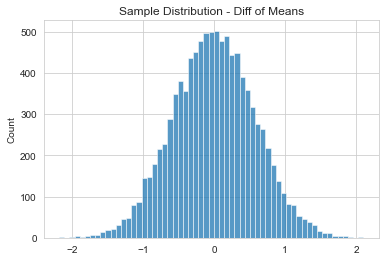

In [12]:
# Plotting the sample distribution
sns.histplot(x=sample_distribution).set(title='Sample Distribution - Diff of Means');

In [13]:
def getpValue(sample_distribution, obs_value, alternative='two-sided'):
    '''
    sample_distribution: the sample distribution
    obs_value: observed value 
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        if obs_value < np.mean(sample_distribution): 
            p_val = 2*ecdf(obs_value)
        else: 
            p_val = 2*(1-ecdf(obs_value)) 
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [14]:
def hyp_test(sampl_value, sampl_distribution, alpha=0.05, alternative='two-sided'):
    '''
    sampl_value: observed value calculated from the sample
    sampl_distribution: sample distribution calculated from the sample
    alpha: significance level
    alternative: one of the three values: 'two-sided', 'smaller', and 'larger'
    '''
    sigHa = {'two-sided':'!=', 'smaller':'< ', 'larger':'> '}
    print('--- Permutation Hypothesis Test ---')
    sns.kdeplot(x=sampl_distribution, color='lightskyblue', shade=True, alpha=0.4)  # plotting the sample distribution
    plt.axvline(x=sampl_value, ymin=0, ymax= 0.03, color='black', linewidth=6)      # plotting the statistic 
    plt.title('Sampling Distribution')
    p_val = getpValue(sampl_distribution, sampl_value, alternative)
    if alternative=='two-sided':                    # plotting the graph with two critical regions
        cv1 = np.round(np.percentile(sampl_distribution, (alpha/2)*100),2)          # left critical value    
        cv2 = np.round(np.percentile(sampl_distribution, 100-alpha*100),2)          # right critical value  
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    elif alternative=='smaller':                    # plotting the graph with left critical region
        cv1 = np.round(np.percentile(sampl_distribution, alpha*100),2)              # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    else:                                           # plotting the graph with right critical region
        cv2 = np.round(np.percentile(sampl_distribution, 100-alpha*100),2)          # right critical value 
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    print('Observed Value = %.2f\tp-value = %.4f' %(sampl_value, p_val))  

--- Permutation Hypothesis Test ---
Observed Value = -4.99	p-value = 0.0000


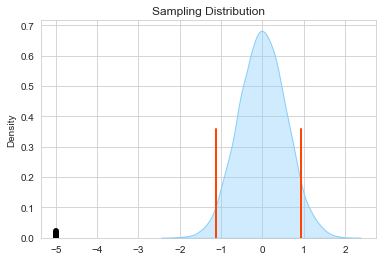

In [15]:
hyp_test(dMeans, sample_distribution)

### Summarizing the procedure

In [16]:
def PT_2iHT(sample1, sample2, num_samples=10000, alpha=0.05, alternative='two-sided'):
    '''
    Permutation hypothesis test for 2 independent samples
    '''
    stat = np.mean(sample1) - np.mean(sample2)
    df1, df2 = generateSamplesPerm_2i(sample1, sample2, num_samples=num_samples)
    sample_distrib = df1.mean() - df2.mean()
    hyp_test(stat, sample_distrib, alpha=alpha, alternative=alternative)

--- Permutation Hypothesis Test ---
Observed Value = -4.99	p-value = 0.0000


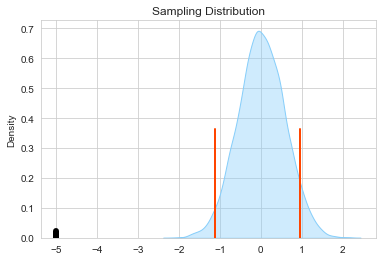

In [17]:
PT_2iHT(classC, classD)

### Analysing other data

In [18]:
np.random.seed(123)
classE = np.random.normal(94.7, 2, 90)
classF = np.random.normal(95.1, 1.5, 95)

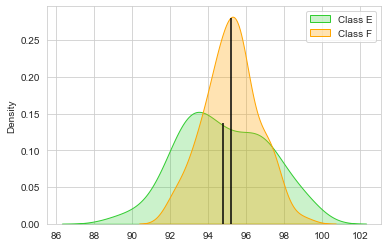

In [19]:
ax=sns.kdeplot(x=classE, color='limegreen', shade=True, label='Class E')
ax.vlines(x=np.mean(classE), ymin=0, ymax=0.137, color='black')
ax=sns.kdeplot(x=classF, color='orange', shade=True, alpha=0.3, label='Class F')
ax.vlines(x=np.mean(classF), ymin=0, ymax=0.28, color='black')
plt.legend();

--- Permutation Hypothesis Test ---
Observed Value = -0.41	p-value = 0.1414


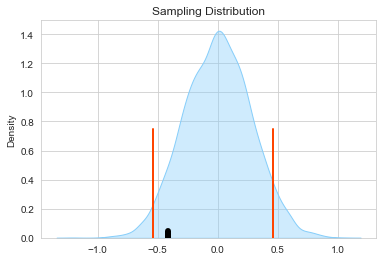

In [20]:
PT_2iHT(classE, classF)

Example 2. We have the amount of money that students spend in books for a semester in one university. 

***Research question***: Do the science students spend more money on books as average than art students?

**Hypothesis**:
- Ho: mean_science = mean_art   `or`   mean_science - mean_art = 0
- Ha: mean_science > mean_art   `or`   mean_science - mean_art > 0 

In [21]:
science = [190, 280, 290, 250, 300, 286, 298, 243, 220, 310]
print(np.mean(science))

266.7


In [22]:
art = [280, 260, 250, 220, 240, 260, 270, 260, 250, 300]
print(np.mean(art))

259.0


--- Permutation Hypothesis Test ---
Observed Value = 7.70	p-value = 0.5994


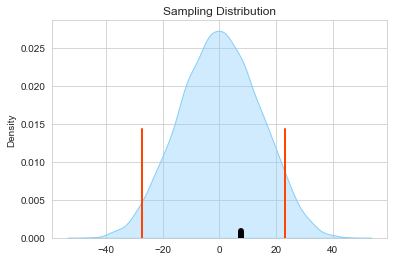

In [23]:
PT_2iHT(science, art)

We have no reasons for rejecting the null hypothesis. 

The spending of science and art students on books are similar on average.

## Permutation Test for two Paired Samples Hypothesis Test

Remember:
- Ho: mean(grade_before) == mean(grade_after)
- Ha: mean(grade_before) != mean(grade_after)

mean(grade_before) == mean(grade_after) is equivalent to diff == 0
diff = mean(grade_before) - mean(grade_after)

We can reformulate the hypothesis as:
- Ho: diff == 0
- Ha: diff != 0

If we swap the before and after values of some students, the result will be the same under H0. This is the main idea of the permutation test for paired data.

The idea of the permutation test for paired samples is to swap the pair values for some cases. If you have 3 - 2 = 1, and you swap the values 3 and 2, you will get 2 - 3 = -1. Swapping the values and calculating the difference is equivalent to multiply by -1 that difference.

In [24]:
np.random.seed(12)
grade_before = np.random.normal(85.5, 3, 80)
grade_after  = np.random.normal(86,   4, 80)
grade_after2 = np.random.normal(90,   3, 80)

In [25]:
# Creating a new variable: the difference between both grades
diff = grade_after - grade_before

In [26]:
test_stat = np.mean(diff)
test_stat

0.2188556942747198

In [27]:
def generateSamplesPerm_2p(sample, num_samples=10000):
    '''
    It concatenates both samples, shuffle it, and creates two new samples with 
    the same length of the originals. 
    It returns two DataFrames, where each column is a sample without replacement.
    '''
    col = ['S'+str(k) for k in range(num_samples)]
    df = pd.DataFrame(sample[0], index=range(len(sample)), columns=col)
    for c in col:
        sign = [1 if np.random.rand() > 0.5 else -1 for i in range(len(sample))]
        df[c] = sample * sign
    return(df)

In [28]:
df_1 = generateSamplesPerm_2p(diff, num_samples=10000)
print(df_1.shape)

(80, 10000)


We are going to use the mean of the diferences as our statistic test.

In [29]:
sample_distribution_diff = df_1.mean()

Let's use the function for hypothesis testing.

--- Permutation Hypothesis Test ---
Observed Value = 0.22	p-value = 0.7268


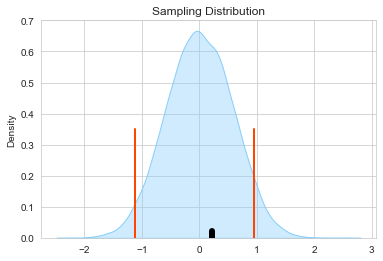

In [30]:
#Graph_Resampling_Hypothesis_Test(mean_diff, test_stat)
hyp_test(test_stat, sample_distribution_diff)

**Example 2**: Analyzing `grade_before` - `grade_after2`

In [31]:
diff2 = grade_after2 - grade_before

The mean of the differences `diff2` is going to be our statistic.

In [32]:
test_stat2 = np.mean(diff2)
test_stat2

4.069149842516363

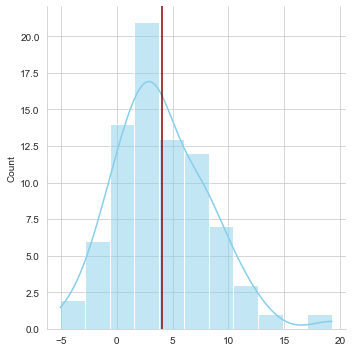

In [33]:
sns.displot(x=diff2, kde='True', color='skyblue')
plt.axvline(x=test_stat2, color='darkred');

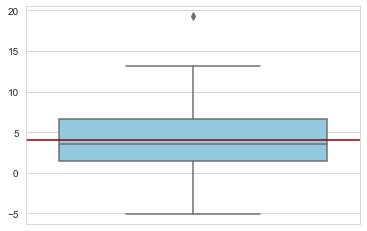

In [34]:
sns.boxplot(y=diff2, color='skyblue')
plt.axhline(y=test_stat2, color='darkred');

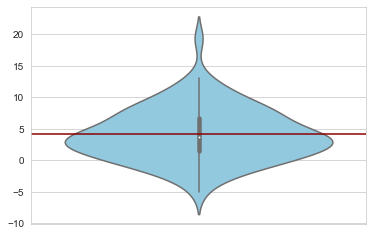

In [35]:
sns.violinplot(y=diff2, color='skyblue')
plt.axhline(y=test_stat2, color='darkred');

Remember:
- Ho: mean(grade_before) == mean(grade_after2)
- Ha: mean(grade_before) != mean(grade_after2)

mean(grade_before) == mean(grade_after2) is equivalent to mean(diff2) == 0
where diff2 = mean(grade_before) - mean(grade_after2)

We can reformulate the hypothesis as:
- Ho: mean(diff2) == 0
- Ha: mean(diff2) != 0

In [36]:
df_2 = generateSamplesPerm_2p(diff2, num_samples=10000)
print(df_2.shape)

(80, 10000)


In [37]:
sample_distribution_diff2 = df_2.mean()

--- Permutation Hypothesis Test ---
Observed Value = 4.07	p-value = 0.0000


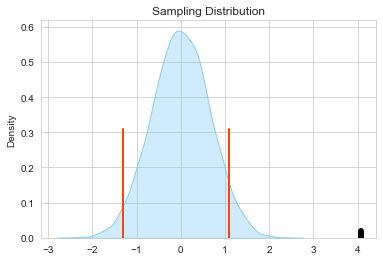

In [38]:
#Graph_Resampling_Hypothesis_Test(mean_diff2, test_stat2)
hyp_test(test_stat2, sample_distribution_diff2)

--- Permutation Hypothesis Test ---
Observed Value = 4.07	p-value = 0.0000


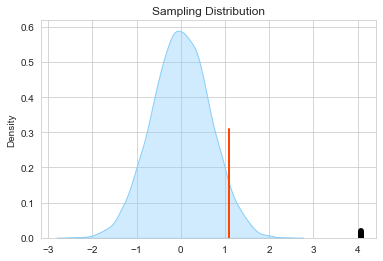

In [39]:
#Graph_Resampling_Hypothesis_Test(mean_diff2, test_stat2, alternative='larger')
hyp_test(test_stat2, sample_distribution_diff2, alternative='larger')

**Example 3**: The data represent the observed pollution indexes of air samples in two areas of a city. Test the hypothesis that the mean pollution indexes are the same for the two areas. 

In [40]:
areaA = np.array([2.92, 1.88, 5.35, 3.81, 4.69, 4.86, 5.81, 5.55])
areaB = np.array([1.84, 0.95, 4.26, 3.18, 3.44, 3.69, 4.95, 4.47])

In [41]:
diff3 = areaB - areaA

In [42]:
test_stat3 = np.mean(areaB) - np.mean(areaA)
test_stat3

-1.0112500000000004

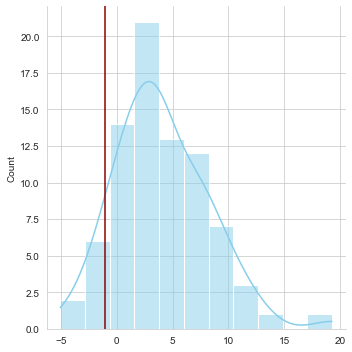

In [43]:
sns.displot(x=diff2, kde='True', color='skyblue')
plt.axvline(x=test_stat3, color='darkred');

In [44]:
df_3 = generateSamplesPerm_2p(diff3, num_samples=10000)
print(df_3.shape)

(8, 10000)


In [45]:
sample_distribution_diff3 = df_3.mean()

--- Permutation Hypothesis Test ---
Observed Value = -1.01	p-value = 0.0000


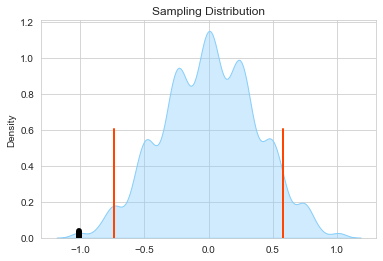

In [46]:
#Graph_Resampling_Hypothesis_Test(mean_diff3, test_stat3)
hyp_test(test_stat3, sample_distribution_diff3)

Reference:
- Good, P. (2005) Permutation, Parametric, and Bootstrap Tests of Hypothesis, Third Edition, USA: Springer Series in Statistics